<a href="https://colab.research.google.com/github/sabre-code/tweet-emotion/blob/main/tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers[torch]
!pip install datasets

  Using cached datasets-2.14.4-py3-none-any.whl (519 kB)
  Using cached dill-0.3.7-py3-none-any.whl (115 kB)
  Using cached xxhash-3.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached multiprocess-0.70.15-py310-none-any.whl (134 kB)


In [4]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers import AutoTokenizer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
emotions = load_dataset("emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
# df = emotions['train'][:]
# df.head()

In [8]:
def label_int2str(row):
 return emotions["train"].features["label"].int2str(row)

In [9]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()


NameError: ignored

In [10]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')

In [12]:
print(tokenize(emotions["train"][:3]))

{'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102],
        [  101, 10047,  9775,  1037,  3371,  2000,  2695,  1045,  2514, 20505,
          3308,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [13]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [15]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt, num_labels=num_labels)
 .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="weighted")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}


In [17]:
from huggingface_hub import notebook_login
notebook_login()


In [36]:
from transformers import Trainer, TrainingArguments
optim = torch.optim.Adam(model.parameters(), lr=5e-5)

batch_size = 32
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
  num_train_epochs=3,
  #learning_rate=2e-5,
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  #weight_decay=0.01,
  #evaluation_strategy="epoch",
  #disable_tqdm=False,
  logging_steps=logging_steps,
  push_to_hub=True,
  )

In [35]:
# import shutil
# shutil.rmtree('distilbert-base-uncased-finetuned-emotion')

In [37]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
  compute_metrics=compute_metrics,
  train_dataset=emotions_encoded["train"],
  eval_dataset=emotions_encoded["validation"],
  tokenizer = tokenizer,
  optimizers=(optim, None))


trainer.train();

Step,Training Loss
500,0.080700
1000,0.058400
1500,0.028100


In [21]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [22]:
preds_output.metrics

{'test_loss': 0.13371527194976807,
 'test_accuracy': 0.937,
 'test_f1': 0.9371228628738675,
 'test_runtime': 4.6448,
 'test_samples_per_second': 430.592,
 'test_steps_per_second': 13.564}

In [ ]:
model_ckpt = "sabre-code/distilbert-base-uncased-finetuned-emotion"

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
# load model with config
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)
# export model
model.save_pretrained(target_name_or_path)

In [27]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "sabre-code/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [28]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


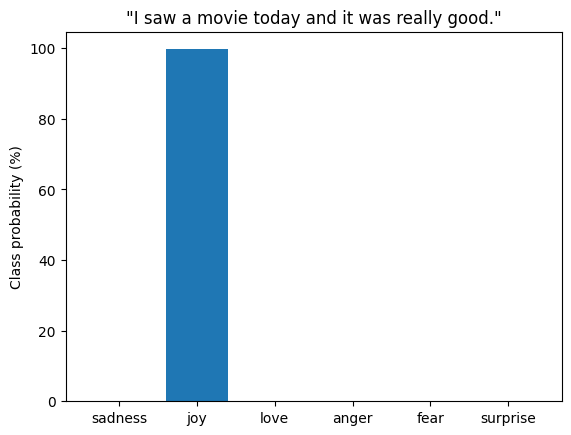

In [30]:
import matplotlib.pyplot as plt
labels = emotions["train"].features["label"].names
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()
